In [1]:
import torch
import model_loader
import pipeline
from PIL import Image
from transformers import CLIPTokenizer

/home/mlfavorfit/anaconda3/envs/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

## Device Check

In [3]:
DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

Using device: cuda


## Load CLIP model

In [4]:
tokenizer = CLIPTokenizer("./data/vocab.json", merges_file="./data/merges.txt")

## Useful function

In [5]:
from PIL import Image
import random

def convert_to_random_color_tiles(colors, weights, image_size=[512,512], tile_num_per_row=4):
    # 이미지 열기
    img = Image.new('RGB', image_size)

    # 이미지 크기 가져오기
    width, height = img.size
    tile_size = (512//tile_num_per_row, 512//tile_num_per_row)

    # 타일별로 이미지를 자르고 랜덤한 색상의 타일로 대체
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # 랜덤하게 색상 섞기
            seleted_color = random.choices(colors, weights, k=1)[0]

            # 랜덤한 타일 생성
            tile = Image.new('RGB', tile_size, seleted_color)

            # 원본 이미지에 랜덤한 타일 적용
            img.paste(tile, (x, y, x + tile_size[0], y + tile_size[1]))

    # 결과 이미지 저장 또는 표시
    # img.show()
    return img

## Controlnet
---

In [6]:
from safetensors.torch import load_file
from model_converter import convert_model, convert_lora_model

In [91]:
diffusion_state_dict = torch.load("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/realisticVisionV60B1_v60B1VAE.pth")
control_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/outpaint_v2.pth")

lora_state_dict = load_file("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/lora/train/pytorch_lora_weights.safetensors")
lora_state_dict = convert_lora_model(lora_state_dict)

diffusion_state_dict["lora"] = lora_state_dict

In [99]:
from model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_controlnet":True, "controlnet_scale":1.0, "is_lora":True, "lora_scale":1.0}
# kwargs = {"is_controlnet":True, "controlnet_scale":1.0}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model(control_state_dict)

models.update(controlnet)

Text(0.5, 1.0, 'control_image')

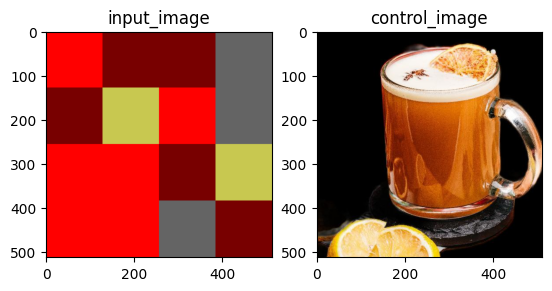

In [110]:
from PIL import Image

# input_image = Image.open("./images/object_colortile/test4.jpg").convert("RGB")
input_image = convert_to_random_color_tiles([tuple(cur) for cur in 
                                             [[255, 0, 0], [120, 0, 0], [100, 100, 100], [200, 200, 80]]
                                             ],
                                            [0.431, 0.239, 0.222, 0.112])
input_image = input_image.resize((512,512))

control_image = Image.open("./images/object_colortile/test5.jpg").convert("RGB")
control_image = control_image.resize((512,512))

import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.imshow(input_image)
plt.title("input_image")
plt.subplot(1,2,2)
plt.imshow(control_image)
plt.title("control_image")

100%|██████████| 16/16 [00:02<00:00,  6.64it/s]


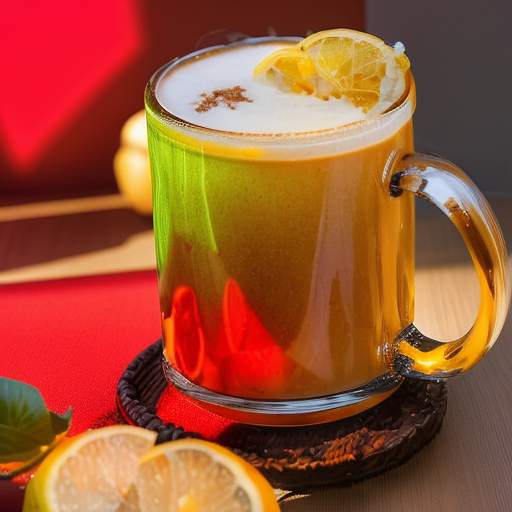

In [149]:
target_prompt = "coffee cup and lemons"

output_image = pipeline.generate_controlnet(
    prompt=f"professional photography, natural shadow, {target_prompt}, realistic, high resolution, 8k",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=input_image,
    control_image=control_image,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=0.8,
    models=models,
    seed=42,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer
)

Image.fromarray(output_image)

Settings -> Mode=fast, Device=cuda, Torchscript=disabled


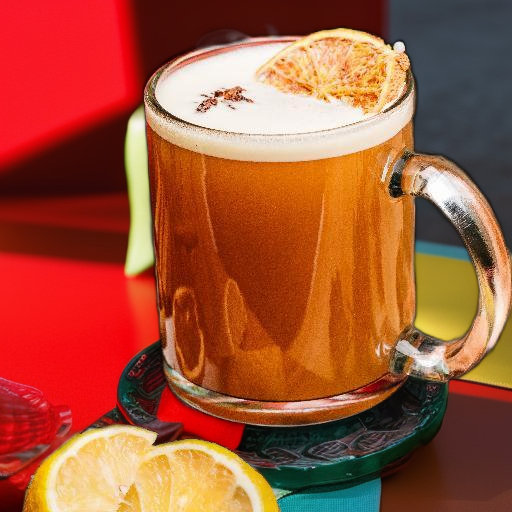

In [146]:
from transparent_background import Remover
import numpy as np

remover = Remover(mode="fast", device="cuda")
mask = remover.process(control_image, type="map")
mask_np = np.array(mask)/255.0

output_image_np = np.array(output_image)
control_image_np = np.array(control_image)

compose_np = output_image_np * (1-mask_np) + control_image_np * mask_np
Image.fromarray(compose_np.astype(np.uint8))

In [62]:
(control_image_np != 0).shape

(512, 512, 3)

## Color palette embedding
---

In [6]:
from model_converter import convert_model
import torch

In [7]:
diffusion_state_dict = torch.load("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/v1-5-pruned-emaonly.ckpt")["state_dict"]
diffusion_state_dict = convert_model(diffusion_state_dict)

2024-01-22 16:02:08.048487: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-22 16:02:08.049467: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-22 16:02:08.068421: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 16:02:08.461365: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [8]:
from model_loader import load_diffusion_model, load_color_palette_embedding_model
models = load_diffusion_model(diffusion_state_dict)
embedding = load_color_palette_embedding_model(state_dict=None)

models.update(embedding)

100%|██████████| 20/20 [00:01<00:00, 11.81it/s]


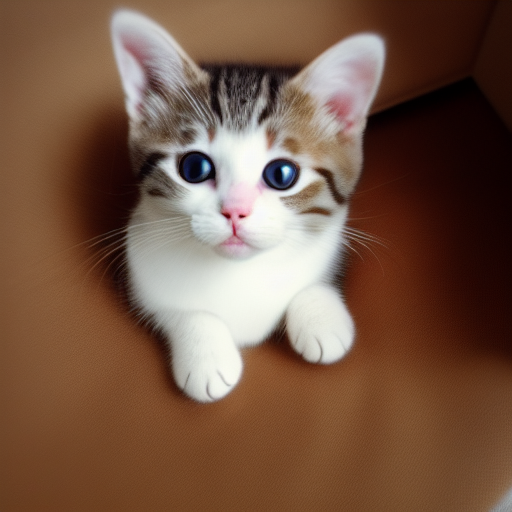

In [9]:
output_image = pipeline.generate_color_palette_embedding(
    prompt="the cute cat",
    uncond_prompt="",
    color_palette=[[31, 29, 27], [135, 137, 145], [94, 92, 97], [68, 66, 70]],
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    models=models,
    seed=42,
    device="cuda",
    idle_device="cpu",
    tokenizer=tokenizer,
)

Image.fromarray(output_image)

## Lora

---

In [5]:
from safetensors.torch import load_file
from model_converter import convert_model, convert_lora_model

In [6]:
diffusion_state_dict = torch.load("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/v1-5-pruned-emaonly.ckpt")["state_dict"]
diffusion_state_dict = convert_model(diffusion_state_dict)

lora_state_dict = load_file("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/lora/train/pytorch_lora_weights.safetensors")
lora_state_dict = convert_lora_model(lora_state_dict)

diffusion_state_dict["lora"] = lora_state_dict

2024-01-19 09:36:07.480129: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 09:36:07.481090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 09:36:07.499434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 09:36:07.895116: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
from model_loader import load_diffusion_model

kwargs = {"is_lora":True, "lora_scale":1.0}
models = load_diffusion_model(diffusion_state_dict, **kwargs)

In [14]:
len([cur for cur in models['diffusion'].state_dict().keys() if "lora" in cur])

256

100%|██████████| 20/20 [00:02<00:00,  7.84it/s]


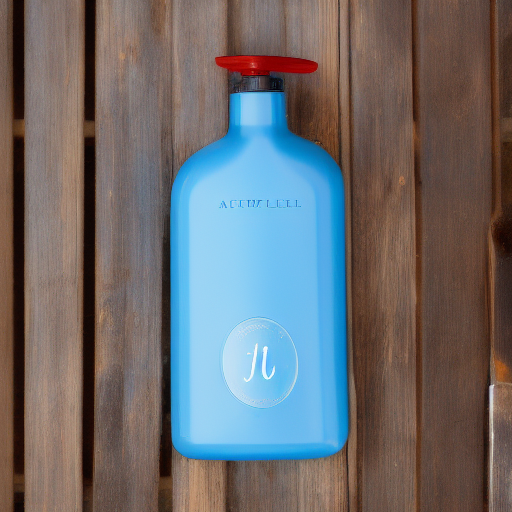

In [8]:
output_image = pipeline.generate(
    prompt="A blue bottle",
    uncond_prompt="deform, low quality",
    input_image=None,
    do_cfg=True,
    cfg_scale=8,
    sampler_name="ddpm",
    n_inference_steps=20,
    seed=42,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

Image.fromarray(output_image)